# **HOME CREDIT SCORE CARD MODEL - DATA SCIENTIST VIRTUAL INTERNSHIP**

###**Problem Statement** :  
Home Credit dihadapi tantangan dalam memastikan bahwa pelanggan yang mampu melakukan pelunasan tidak ditolak ketika mengajukan pinjaman. Dengan begitu, perusahaan dapat menjaga bahkan meningkatkan profitabilitasnya.

###**Goal** :  
Meminimalkan penolakan terhadap customer yang mampu melakukan pelunasan dan meminimalisir jumlah customer yang memiliki kesulitan pembayaran pinjaman

###**Objective** :  
1. Menganalisis faktor-faktor yang mempengaruhi keberhasilan atau tidaknya pelunasan pinjaman.
2. Membangun model machine learning untuk memprediksi kemampuan customer melakukan pelunasan pinjaman



### **Data**

Data disediakan oleh **Home Credit**, yang merupakan perusahaan pembiayaan berbasis teknologi yang menyediakan layanan pinjaman kepada customernya. Terdapat beberapa file yang disediakan, namun dalam analisis ini hanya menggunakan beberapa data berikut :
1. **Application_train/test** : Tabel utama yang menyimpan informasi mengenai setiap pengajuan pinjaman di Home Credit. Setiap baris mewakili pinjaman yang diajukan dengan masing-masingnya diidentifikasikan oleh SK_ID_CURR. Pada data application_train terdapat **TARGET** yang menunjukkan **0** (pinjaman berhasil dilunasi) dan **1** (pinjaman tidak dilunasi)

2. **Bureau** : Tabel yang menyimpan informasi mengenai kredit customer sebelumnya dari lembaga keuangan lain. Setiap kredit yang dilakukan sebelumnya memiliki baris tersendiri di burear, namun satu pinjaman di application data dapat memiliki beberapa kredit sebelumnya.

3. **Previous_application** : Tabel yang menyimpan informasi mengenai pengajuan pinjaman yang sebelumnya diajukan oleh customer di Home Credit.

## **Import Library**

In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.stats import chi2_contingency
from scipy.stats import randint as sp_randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import re

## **Load Data**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path dataset disimpan
path = '/content/drive/MyDrive/PBI/home-credit-default-risk/'

main_train = pd.read_csv(path + 'application_train.csv')
main_test = pd.read_csv(path + 'application_test.csv')

In [4]:
main_train.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
232184,368929,0,Cash loans,M,Y,Y,0,225000.0,425133.0,27810.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0
11770,113718,0,Cash loans,M,Y,Y,1,135000.0,122256.0,7956.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
197424,328895,0,Cash loans,F,N,Y,1,112500.0,961146.0,28233.0,...,0,0,0,0,0.0,0.0,1.0,0.0,0.0,7.0
246677,385473,0,Cash loans,F,N,Y,1,315000.0,1467612.0,62311.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,0.0
165132,291423,1,Cash loans,M,Y,Y,0,126000.0,395766.0,20335.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0


In [5]:
main_test.sample(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
14340,203358,Cash loans,M,Y,Y,0,135000.0,346968.0,20047.5,274500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
15337,210597,Cash loans,M,N,Y,0,157500.0,280170.0,33381.0,247500.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
18156,231835,Cash loans,F,Y,Y,0,241123.5,1350000.0,57330.0,1350000.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
15184,209393,Cash loans,F,N,N,0,157500.0,248760.0,24601.5,225000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
355,102439,Cash loans,F,N,Y,0,45000.0,539100.0,23877.0,450000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


In [6]:
bureau = pd.read_csv(path + 'bureau.csv')

In [7]:
bureau.sample(5)

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
801182,322266,6508908,Closed,currency 1,-599,0,1227.0,-385.0,NaN,0,369000.00,0.0,0.0,0.0,Consumer credit,-106,NaN
180289,411142,5705587,Closed,currency 1,-1127,0,-761.0,-793.0,0.0,0,132985.17,0.0,0.0,0.0,Consumer credit,-783,NaN
1465933,318567,6764553,Closed,currency 1,-1699,0,-784.0,-785.0,NaN,0,348475.50,0.0,0.0,0.0,Consumer credit,-780,NaN
586658,279514,6454064,Closed,currency 1,-919,0,9920.0,-901.0,0.0,0,204750.00,NaN,NaN,0.0,Credit card,-901,NaN
756897,415234,5504746,Closed,currency 1,-1087,0,-956.0,-956.0,0.0,0,36895.50,NaN,NaN,0.0,Consumer credit,-950,NaN


In [8]:
prev_app = pd.read_csv(path + 'previous_application.csv')

In [9]:
prev_app.sample(5)

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
121865,1085227,252664,Consumer loans,NaN,40176.0,40176.0,0.0,40176.0,TUESDAY,10,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
1426329,2250067,369219,Cash loans,NaN,0.0,0.0,NaN,NaN,WEDNESDAY,13,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
1255057,2347872,280235,Consumer loans,13916.07,82641.6,66109.5,16532.1,82641.6,TUESDAY,15,...,Connectivity,5.0,low_normal,POS mobile without interest,365243.0,-1142.0,-1022.0,-1052.0,-1045.0,0.0
1157065,2711162,306699,Cash loans,NaN,0.0,0.0,NaN,NaN,SATURDAY,9,...,XNA,NaN,XNA,Cash,NaN,NaN,NaN,NaN,NaN,NaN
822010,2070604,295155,Revolving loans,12375.00,247500.0,247500.0,NaN,247500.0,WEDNESDAY,7,...,XNA,0.0,XNA,Card X-Sell,NaN,NaN,NaN,NaN,NaN,NaN


### Aggregat tabel bureau dan previuos_application

In [10]:
# Menghitung total prev_app tiap customer
total_prev_app = prev_app.groupby('SK_ID_CURR')['SK_ID_CURR'].agg(TOTAL_PREV_APP = 'count').reset_index()
total_prev_app

,SK_ID_CURR,TOTAL_PREV_APP
0,100001,1
1,100002,1
2,100003,3
3,100004,1
4,100005,2
...,...,...
338852,456251,1
338853,456252,1
338854,456253,2
338855,456254,2


In [11]:
# Menghitung total bureau tiap customer
total_bureau = bureau.groupby('SK_ID_CURR')['SK_ID_CURR'].agg(TOTAL_BUREAU = 'count').reset_index()
total_bureau

,SK_ID_CURR,TOTAL_BUREAU
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


Merge total_prev_app dan total_bureau ke dalam application_train

In [12]:
main = pd.merge(main_train, total_prev_app, on='SK_ID_CURR', how='left')
main = pd.merge(main, total_bureau, on='SK_ID_CURR', how='left')

In [13]:
main.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU
157768,282872,0,Cash loans,F,N,Y,0,103500.0,314055.0,13963.5,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN
162887,288830,0,Cash loans,F,N,N,0,77850.0,269982.0,27792.0,...,0,0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
173362,300899,0,Cash loans,M,Y,N,0,292500.0,403249.5,19741.5,...,0,0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,2.0
128005,248469,0,Cash loans,M,Y,N,0,315000.0,983299.5,39127.5,...,0,0,0.0,0.0,0.0,1.0,0.0,0.0,6.0,20.0
91130,205829,1,Cash loans,M,N,Y,2,94500.0,508500.0,33979.5,...,0,0,0.0,0.0,0.0,1.0,0.0,6.0,6.0,3.0


## **Exploratory Data Analysis (EDA)**

In [14]:
print(main.shape)
print(main['SK_ID_CURR'].nunique())

(307511, 124)
307511


Pada dataset main terdapat **307511 baris** (unik) dan 124 kolom.

### **Check Data Types**

In [15]:
main.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 124 columns):
 #    Column                        Dtype  
---   ------                        -----  
 0    SK_ID_CURR                    int64  
 1    TARGET                        int64  
 2    NAME_CONTRACT_TYPE            object 
 3    CODE_GENDER                   object 
 4    FLAG_OWN_CAR                  object 
 5    FLAG_OWN_REALTY               object 
 6    CNT_CHILDREN                  int64  
 7    AMT_INCOME_TOTAL              float64
 8    AMT_CREDIT                    float64
 9    AMT_ANNUITY                   float64
 10   AMT_GOODS_PRICE               float64
 11   NAME_TYPE_SUITE               object 
 12   NAME_INCOME_TYPE              object 
 13   NAME_EDUCATION_TYPE           object 
 14   NAME_FAMILY_STATUS            object 
 15   NAME_HOUSING_TYPE             object 
 16   REGION_POPULATION_RELATIVE    float64
 17   DAYS_BIRTH                    int64  
 18   DA

108 kolom numerik (67 float, 41 integer) dan 16 kolom object. Tipe data sudah sesuai

In [16]:
main.select_dtypes(include='object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

Mayoritas kolom kategori memiliki nilai unique yang sedikit. Kolom kategori ini nantinya akan dilalkukan feature encoding.

### **Missing Values**

In [17]:
miss_val = main.isnull().sum().sort_values(ascending=False).round(2)
misval_percent = round(miss_val / len(main) * 100, 3)
misval_table = pd.concat([miss_val, misval_percent], axis=1, keys=['Total', 'Percentage(%)']).reset_index()
misval_table[misval_table['Percentage(%)'] >= 60 ]

,index,Total,Percentage(%)
0,COMMONAREA_MODE,214865,69.872
1,COMMONAREA_AVG,214865,69.872
2,COMMONAREA_MEDI,214865,69.872
3,NONLIVINGAPARTMENTS_AVG,213514,69.433
4,NONLIVINGAPARTMENTS_MODE,213514,69.433
5,NONLIVINGAPARTMENTS_MEDI,213514,69.433
6,FONDKAPREMONT_MODE,210295,68.386
7,LIVINGAPARTMENTS_MEDI,210199,68.355
8,LIVINGAPARTMENTS_AVG,210199,68.355
9,LIVINGAPARTMENTS_MODE,210199,68.355


In [18]:
len(misval_table[misval_table['Total'] > 0 ])

69

- Dari 124 kolom, **69 kolom** memiliki **missing value**
- **16 kolom** memiliki missing value **lebih dari 60%**
- kolom dengan missing value di atas 60% akan di drop

### **Duplicated row**

In [19]:
main.duplicated().any()

False

Tidak ada data duplikat, setiap baris unik

### **Univariate Analysis**

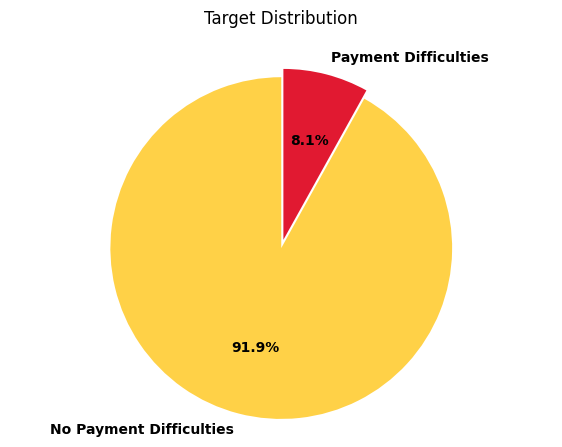

In [20]:
# Membuat grafik pie perbandingan churn
target = main['TARGET'].value_counts()
explode = (0.05, 0)
text_props = {'color': 'black', 'weight': 'bold'}

plt.figure(figsize=(7, 5))
plt.pie(target, labels=['No Payment Difficulties', 'Payment Difficulties'], autopct='%1.1f%%', startangle=90, explode = explode, colors = ['#ffd147','#e11931'], textprops=text_props)
plt.axis('equal')
plt.title('Target Distribution', pad=20)
plt.show()

Terdapat imbalance data pada target, dimana data didominasi oleh no paymet difficulties dengan persentase lebih dari 90% dibanding target lainnya yang hanya 8.1%. Problem imbalance data ini nantinya akan dihandle agar ketidakseimbangan tidak mempengaruhi hasil prediksi terutama untuk kelas minoritas.

In [21]:
# features = ['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'TOTAL_PREV_APP', 'TOTAL_BUREAU']
# num_rows = len(features) // 2 + len(features) % 2

# plt.figure(figsize=(10, 8))

# for i in range(len(features)):
#     plt.subplot(num_rows, 2, i+1)
#     sns.histplot(x=main[features[i]], kde=True, color='#ffd147')
#     plt.xlabel(features[i])

# plt.tight_layout()
# plt.show()


- Kolom `AMT_CREDIT` memiliki distribusi skew positif, di mana mayoritas jumlah kredit (pinjaman) yang diajukan customer bernilai di bawah 1000000.
- Angusuran yang dibayarkan customer kebanyakan di bawah 50000.
- Sepertinya terdapat outlier pada kolom `AMT_INCOME_TOTAL` yang membuat pola grafiknya tidak terlihat
- Pada tipe consumer loans, kebanyakan harga barang yang diberikan pinjaman berada di bawah 1500000

In [22]:
# plt.rcParams['figure.figsize'] = (10, 5)

# for i, feature in enumerate(features, 1):
#     plt.subplot(1, len(features), i)
#     sns.boxplot(y=main[feature], color='#ffd147')
#     plt.xlabel(feature)
#     plt.tight_layout()

# plt.show()

- Terdapat outlier (pencilan) yang nilainya sangat jauh dari batas atas IQR pada kolom `AMT_INCOME_TOTAL`
- Pada kolom `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_GOODS_PRICES, 'TOTAL_PREV_APP`, dan `TOTAL_BUREAU` ditemukan outlier yang berada di atas batas atas IQR
- Dapat dilihat pada kolom `TOTAL_PREV_APP`, terdapat customer yang sangat sering mengajukan pinjaman di Home Credit dengan jumlah mencapai 70+ kali

In [23]:
# Fungsi membuat bar chart untuk feature bertipe kategori
def bar_chart_categories(features):
  features_cat = features
  num_rows = len(features_cat) // 2 + len(features_cat) % 2
  plt.rcParams['figure.figsize'] = (12, 10)
  fig = plt.figure()

  for i in range(0, len(features_cat)):
    ax = plt.subplot(num_rows, 3, i+1)
    value_counts = main[features_cat[i]].value_counts().sort_index()

    sns.countplot(x=(main[features_cat[i]]).sort_values(ascending = True), palette='pastel')

    for x, count in enumerate(value_counts):
      if len(str(value_counts.index[x])) > 5:
        ax.get_xticklabels()[x].set_rotation(75)
        ax.get_xticklabels()[x].set_ha('right')

      plt.text(x, count, str(count), ha='center', va='bottom')

    plt.xlabel(features_cat[i])
    plt.tight_layout()

plt.show()

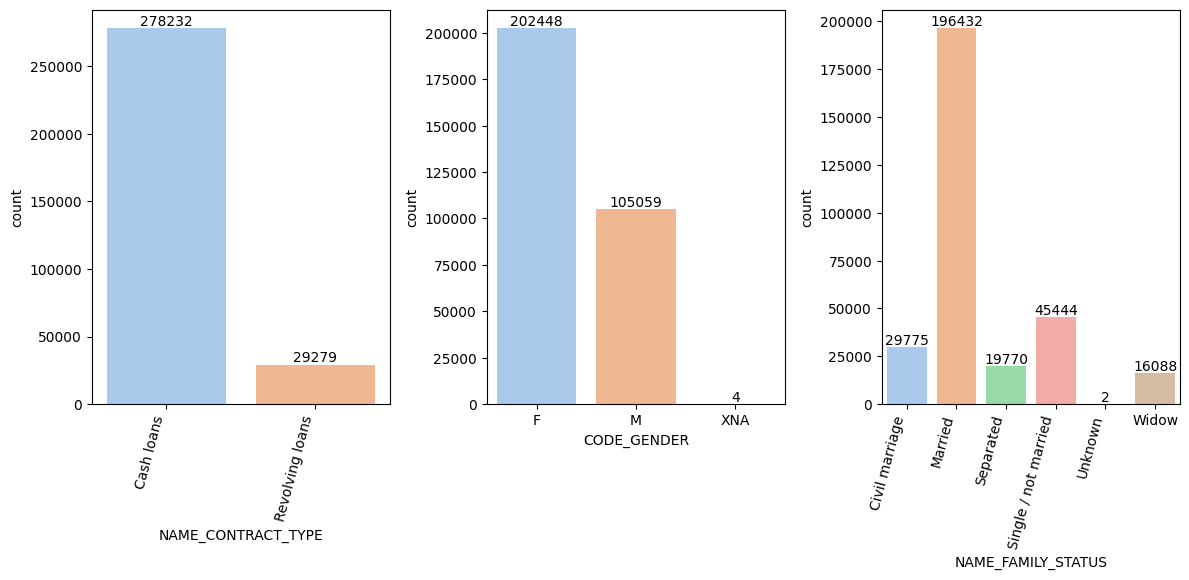

In [24]:
features_cat1 = ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'NAME_FAMILY_STATUS']
bar_chart_categories(features_cat1)

- Tipe contract yang banyak diajukan customer adalah cash loans
- Gender Female (wanita) memiliki frekuensi yang tinggi atau yang paling sering mengajukan pinjaman. Selain itu, terdapat invalid data pada kolom ini yaitu XNA. Invalid data tersebut nanti akan dihandle
- Mayoritas customer yang mengajukan pinjaman adalah yang berstatus married.

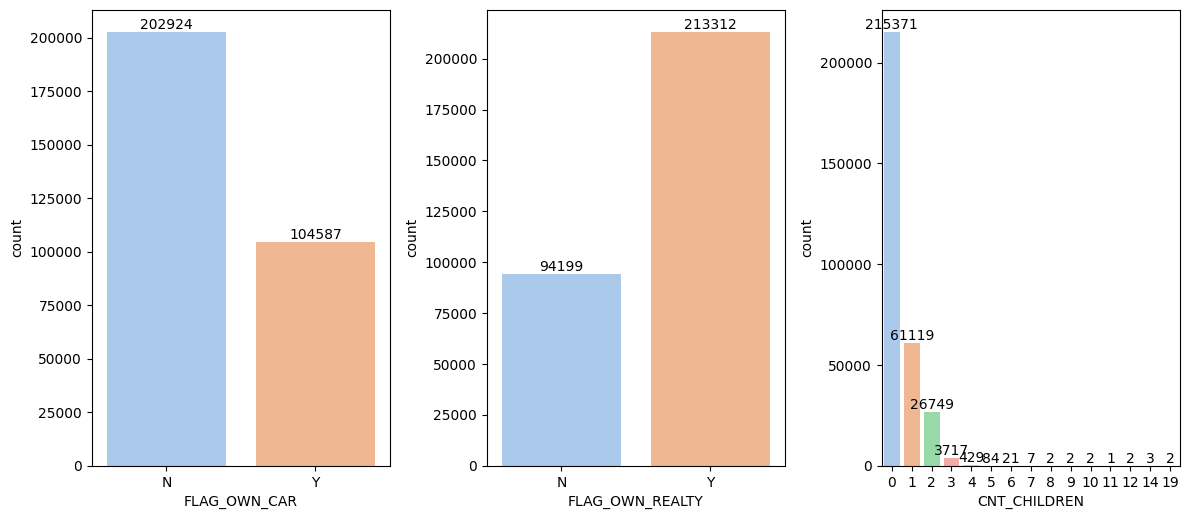

In [25]:
features_cat2 = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN']
bar_chart_categories(features_cat2)

Keterangan :   
**N** : No (tidak punya)  
**Y** : Yes (punya)

- Customer yang mengajukan pinjaman mayoritas tidak memiliki mobil
- Mayoritas customer yang mengajukan pinjaman adalah mereka yang memiliki rumah atau apartemen
- Banyak customer di Home Credit yang mengajukan pinjaman adalah mereka yang tidak memiliki anak


In [26]:
main['OCCUPATION_TYPE'].nunique()

18

In [27]:
# pekerjaan = main['OCCUPATION_TYPE'].unique()

# # Mengkategorikan pekerjaan
# staff_level = ['Sales staff', 'Core staff', 'High skill tech staff',
#                'Medicine staff', 'Private service staff', 'Waiters/barmen staff',
#                'Secretaries', 'HR staff', 'IT staff']

# service_level = ['Laborers', 'Drivers', 'Security staff', 'Cooking staff',
#                  'Cleaning staff', 'Low-skill Laborers']

# management_level = ['Managers', 'Accountants', 'Realty agents']

# # Menambahkan ke dalam data main
# main['OCCUPATION_TYPE_NEW_CAT'] = main['OCCUPATION_TYPE'].apply(lambda x: 'Staff Level' if x in staff_level else
#                                                                   ('Service Level' if x in service_level else
#                                                                    ('Management Level' if x in management_level else 'NaN')))

In [28]:
def occupation_group(pekerjaan):
    staff_level = ['Sales staff', 'Core staff', 'High skill tech staff',
                   'Medicine staff', 'Private service staff', 'Waiters/barmen staff',
                   'Secretaries', 'HR staff', 'IT staff']

    service_level = ['Laborers', 'Drivers', 'Security staff', 'Cooking staff',
                     'Cleaning staff', 'Low-skill Laborers']

    management_level = ['Managers', 'Accountants', 'Realty agents']

    if pekerjaan in staff_level:
        return 'Staff Level'
    elif pekerjaan in service_level:
        return 'Service Level'
    elif pekerjaan in management_level:
        return 'Management Level'
    else:
        return 'NaN'

main['OCCUPATION_TYPE_NEW_CAT'] = main['OCCUPATION_TYPE'].apply(occupation_group)

In [29]:
main_test['OCCUPATION_TYPE_NEW_CAT'] = main_test['OCCUPATION_TYPE'].apply(occupation_group)

Karena kolom `OCCUPATION_TYPE` memiliki nilai unique yang cukup banyak (18), tipe pekerjaan yang ada dikelompokkan kembali menjadi 3 kategori besar yaitu **staff_level, service_level,** dan **management_level**.

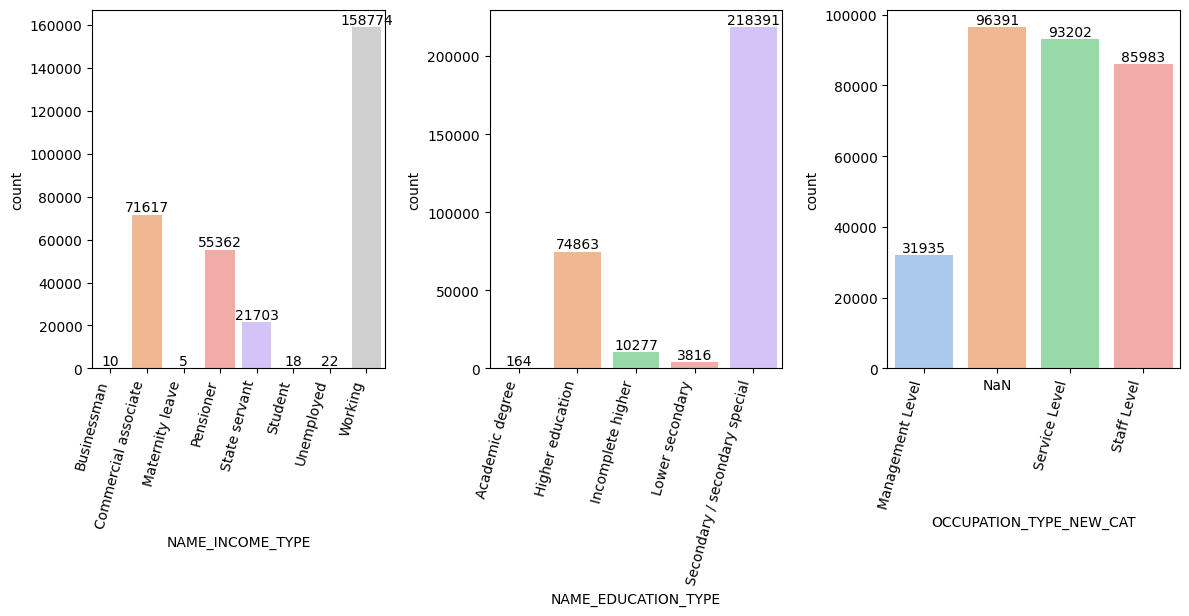

In [30]:
features_cat3 = ['NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'OCCUPATION_TYPE_NEW_CAT']
bar_chart_categories(features_cat3)

Observation :
- Customer yang mengajukan pinjaman mayoritas memiliki pendapatan sebagai pekerja(working) dan yang terendah berasal dari cuti hamil (maternity leave)
- Secondary special merupakan latar belakang edukasi yang paling banyak mengajukan pinjaman yaitu sebanyak 218391
- Pada kolom jenis pekerjaan, frekuensi tertinggi berasal dari missing value (NaN) sebanyak 96391, dan yang memiliki frekuensi tertinggi kedua adalah customer yang bekerja dalam bidang service sebesar 93202. Kolom ini akan dianalisis lebih lanjut terkait problem missing value

### **Multivariate Analysis**

- .00-.19 “very weak”
- .20-.39 “weak”
- .40-.59 “moderate”
- .60-.79 “strong”
- .80-1.0 “very strong”

In [31]:
# Membuat tabel nilai korelasi berdarkan value corr terbesar
corr = main.corrwith(main["TARGET"])
corr = corr.reset_index(name='corr value')
corr["Corr type"] = corr["corr value"].apply(lambda x : "Positif" if x >= 0 else "Negatif")
corr["corr value"] = corr["corr value"].apply(lambda x : abs(x))
corr_sort = corr.sort_values('corr value', ascending=False, ignore_index=True)
corr_sort[corr_sort['corr value'] >= .04]

,index,corr value,Corr type
0,TARGET,1.000000,Positif
1,EXT_SOURCE_3,0.178919,Negatif
2,EXT_SOURCE_2,0.160472,Negatif
3,EXT_SOURCE_1,0.155317,Negatif
4,DAYS_BIRTH,0.078239,Positif
5,REGION_RATING_CLIENT_W_CITY,0.060893,Positif
6,REGION_RATING_CLIENT,0.058899,Positif
7,DAYS_LAST_PHONE_CHANGE,0.055218,Positif
8,DAYS_ID_PUBLISH,0.051457,Positif
9,REG_CITY_NOT_WORK_CITY,0.050994,Positif


In [32]:
age_years = abs(main['DAYS_BIRTH'] / 365)
main['Age_years'] = age_years

In [33]:
age_years = abs(main_test['DAYS_BIRTH'] / 365)
main_test['Age_years'] = age_years

In [34]:
main.drop(columns='DAYS_BIRTH', inplace=True)

In [35]:
main_test.drop(columns='DAYS_BIRTH', inplace=True)

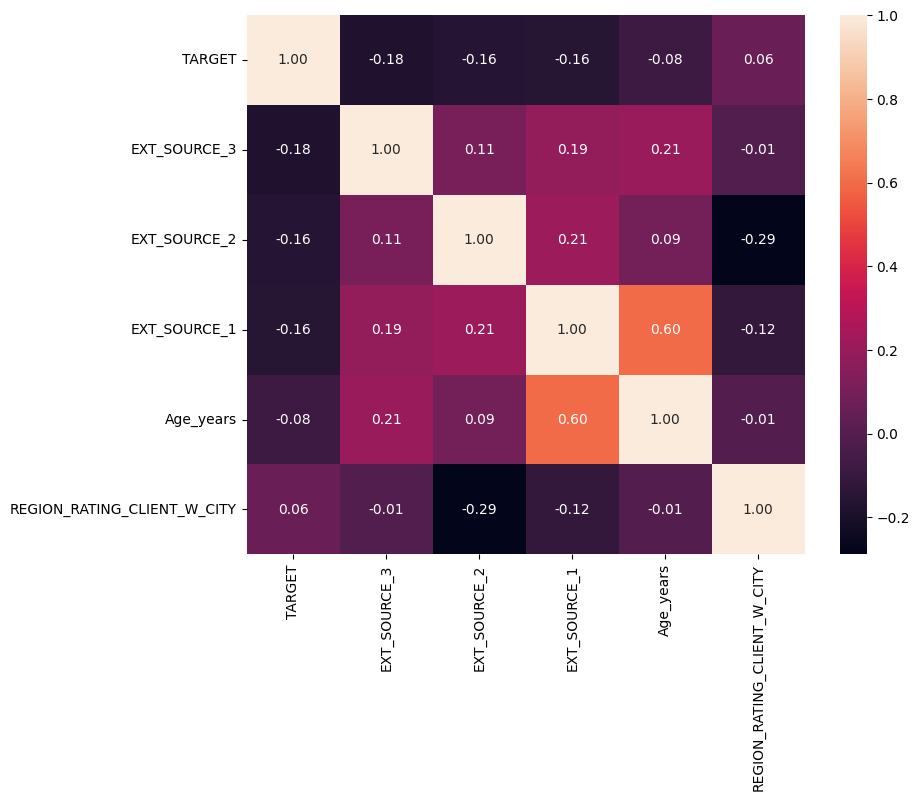

In [36]:
features_nums = ['TARGET','EXT_SOURCE_3', 'EXT_SOURCE_2', 'EXT_SOURCE_1', 'Age_years', 'REGION_RATING_CLIENT_W_CITY']

plt.figure(figsize=(9, 7))
sns.heatmap(data=main[features_nums].corr(), annot=True, fmt='.2f')
plt.show()

- Ketiga feature **EXT_SOURCE** memiliki **korelasi negatif** yang cukup tinggi dengan TARGET. Dapat mengindikasikan bahwa semakin besar nilai EXT_SOURCE, semakin kecil kemungkinan customer akan membayar kembali pinjamannya.
- Age_years (mewakili **DAYS_BIRTH**) memiliki **korelasi negatif** dengan TARGET sebesar -0.08. Ini berarti dapat mengindikasikan bahwa semakin besar usia customer, semakin kecil kemungkinan customer membayar pinjamannya
- **REGION_RATING_CLIENT_W_CITY** memiliki **korelasi positif** dengan TARGET. Ini dapat menunjukkan bahwa customer yang tinggal di wilayah rating tinggi berkemungkinan besar akan memiliki kesulitan membayar pinjaman
- EXT_SOURCE1 memiliki korelasi positif yang sangat tinggi dengan Age_years. Ini menunjukkan bahwa mungkin salah satu faktor yang mempengaruhi niali EXT_SOURCE_1 adalah usia customer

In [37]:
# sns.pairplot(main[features_nums], hue='TARGET',diag_kind='kde', palette=['#ffd147','#e11931'])
# plt.show()

Ditemukan pola yang menarik pada EXT_SOURCE_3 dan EXT_SOURCE_1 dengan variabel target, terlihat pada grafik terdapat kecemderungan bahwa banyak customer yang memiliki kesulitan pembayaran pinjaman pada nilai EXT_SOURCE yang lebih kecil, sebaliknya jika nilai EXT_SOURCE semakin besar maka customer cenderung tidak memiliki masalah pembayaran pinjaman.

**Pengaruh Usia**

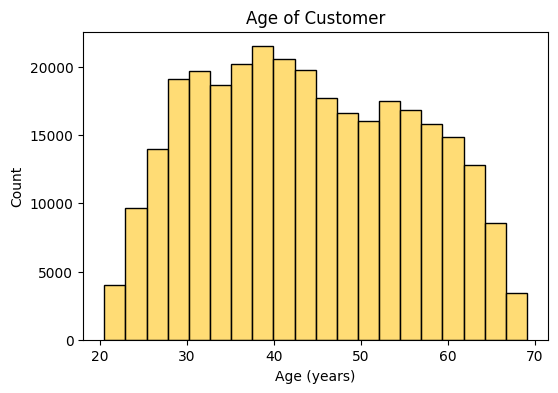

In [38]:
plt.figure(figsize=(6,4))
sns.histplot(main['Age_years'], edgecolor = 'k', bins = 20, color='#ffd147')
plt.title('Age of Customer')
plt.xlabel('Age (years)')
plt.ylabel('Count');

Usia klien yang mengajukan pinjaman di Home Credit berada dalam rentang di atas 20 tahun hingga di bawah 70 tahun

### **Business Insight**

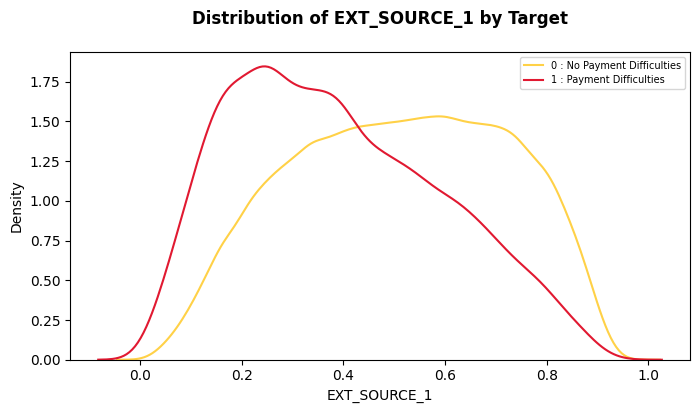

In [39]:
plt.figure(figsize=(8, 4))

sns.kdeplot(main.loc[main['TARGET'] == 0, 'EXT_SOURCE_1'], label= '0 : No Payment Difficulties', color='#ffd147')
sns.kdeplot(main.loc[main['TARGET'] == 1, 'EXT_SOURCE_1'], label= '1 : Payment Difficulties', color='#e11931', )
plt.title('Distribution of EXT_SOURCE_1 by Target', fontweight='bold', pad=20)
plt.xlabel('EXT_SOURCE_1')
plt.ylabel('Density')
plt.legend(fontsize='7')
plt.show()

Terdapat kecenderungan bahwa **semakin kecil nilai EXT_SOURCE_1**, semakin besar kemungkinan customer tersebut mengalami **kesulitan pembayaran pinjaman**

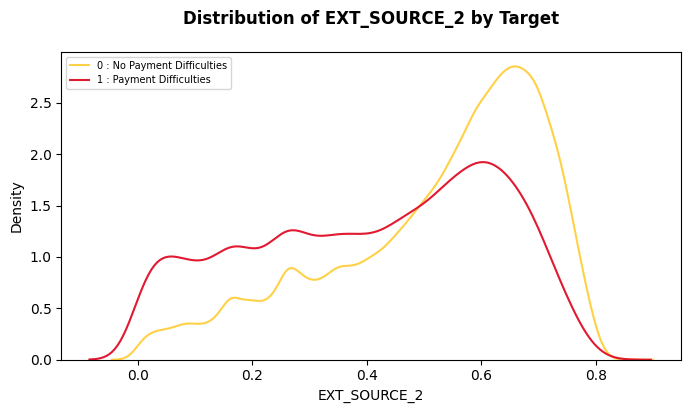

In [40]:
plt.figure(figsize=(8, 4))

sns.kdeplot(main.loc[main['TARGET'] == 0, 'EXT_SOURCE_2'], label= '0 : No Payment Difficulties', color='#ffd147')
sns.kdeplot(main.loc[main['TARGET'] == 1, 'EXT_SOURCE_2'], label= '1 : Payment Difficulties', color='#e11931', )
plt.title('Distribution of EXT_SOURCE_2 by Target', fontweight='bold', pad=20)
plt.xlabel('EXT_SOURCE_2')
plt.ylabel('Density')
plt.legend(fontsize='7')
plt.show()

Customer dengan nilai EXT_SOURCE_2 dalam rentang **kurang dari 0 - 0.5** memiliki kemungkinan **kesulitan pembayaran** pinjaman yang sangat tinggi.

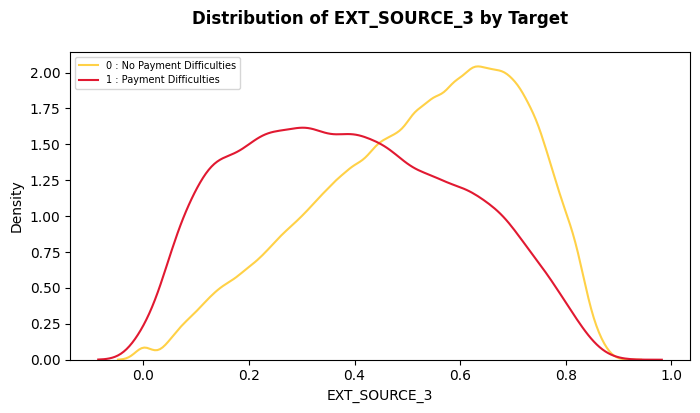

In [41]:
plt.figure(figsize=(8, 4))

sns.kdeplot(main.loc[main['TARGET'] == 0, 'EXT_SOURCE_3'], label= '0 : No Payment Difficulties', color='#ffd147')
sns.kdeplot(main.loc[main['TARGET'] == 1, 'EXT_SOURCE_3'], label= '1 : Payment Difficulties', color='#e11931', )
plt.title('Distribution of EXT_SOURCE_3 by Target', fontweight='bold', pad=20)
plt.xlabel('EXT_SOURCE_3')
plt.ylabel('Density')
plt.legend(fontsize='7')
plt.show()

Terdapat kecendurangan bahwa **semakin kecil nilai EXT_SOURCE_3** (di bawah 0.5), semakin tinggi kemungkinan customer **mengalami kesulitan pembayaran** pinjaman. Customer yang memiliki skor EXT_SOURCE_3 di atas 0.5 cenderung tidak mengalami kesulitan pembayaran.

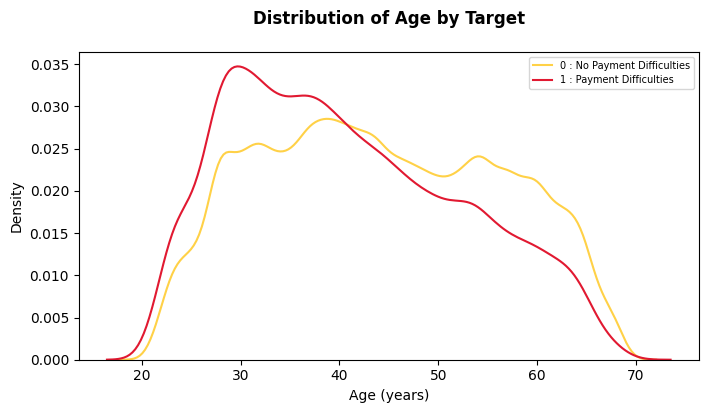

In [42]:
plt.figure(figsize=(8, 4))

sns.kdeplot(main.loc[main['TARGET'] == 0, 'Age_years'], label= '0 : No Payment Difficulties', color='#ffd147')
sns.kdeplot(main.loc[main['TARGET'] == 1, 'Age_years'], label= '1 : Payment Difficulties', color='#e11931', )
plt.title('Distribution of Age by Target', fontweight='bold', pad=20)
plt.xlabel('Age (years)')
plt.ylabel('Density')
plt.legend(fontsize='7')
plt.show()

Berdasarkan grafik tersebut, terlihat kecenderungan bahwa klien dengan usia yang lebih muda cenderung mengalami kesulitan pembayaran pinjaman. Sebaliknya, klien dengan usia yang lebih tua cenderung untuk dapat melunasi pinjamannya

Untuk lebih jelas, umur tiap klien akan dikelompokkan untuk lebih memperjelas rentang usia customer yang mengalami kesulitan pembayaran

In [43]:
age_data = main[['TARGET', 'Age_years']]

age_data.loc[:, 'YEARS_BINNED'] = pd.cut(age_data['Age_years'], bins=np.linspace(20, 70, num=11))

<ipython-input-43-70d9d62ce657>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_data.loc[:, 'YEARS_BINNED'] = pd.cut(age_data['Age_years'], bins=np.linspace(20, 70, num=11))


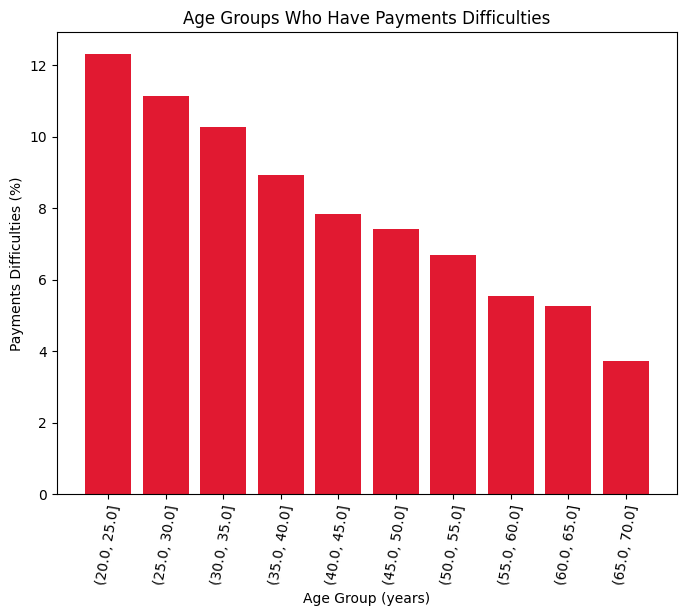

In [44]:
age_groups  = age_data.groupby('YEARS_BINNED').mean()
plt.figure(figsize = (8, 6))

plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'], color='#e11931')

plt.xticks(rotation = 80); plt.xlabel('Age Group (years)'); plt.ylabel('Payments Difficulties (%)')
plt.title('Age Groups Who Have Payments Difficulties');

Terlihat jelas bahwa **kelompok usia yang lebih muda** cenderung untuk mengalami **kesulitan membayar pinjaman**. Di mana 3 kelompok usia termuda memiliki persentase gagal bayar di atas 10%.

Dalam hal ini, 3 kelompok usia termuda yang dimaksud adalah klien dalam rentang usia 20-25, 25-30, dan 35-40 tahun (20-40 tahun).

## **Data Pre-processing**

### Handling Invalid Data

#### training

In [45]:
for cat in main.select_dtypes(include='object').columns:
  print(f'\nValue count kolom {cat}: ')
  print(main[cat].value_counts())
  print()


Value count kolom NAME_CONTRACT_TYPE: 
Cash loans         278232
Revolving loans     29279
Name: NAME_CONTRACT_TYPE, dtype: int64


Value count kolom CODE_GENDER: 
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64


Value count kolom FLAG_OWN_CAR: 
N    202924
Y    104587
Name: FLAG_OWN_CAR, dtype: int64


Value count kolom FLAG_OWN_REALTY: 
Y    213312
N     94199
Name: FLAG_OWN_REALTY, dtype: int64


Value count kolom NAME_TYPE_SUITE: 
Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64


Value count kolom NAME_INCOME_TYPE: 
Working                 158774
Commercial associate     71617
Pensioner                55362
State servant            21703
Unemployed                  22
Student                     18
Businessman                 10
Maternity leave              5
Name: NAME_INCOME_TYPE, dtyp

Terdapat value 'XNA' pada kolom `CODE_GENDER` dan `ORGANIZATION_TYPE` yang mungkin saja bagian dari kesalahan input.

In [46]:
main['CODE_GENDER'].replace("XNA", np.nan, inplace=True)
main['ORGANIZATION_TYPE'].replace("XNA", np.nan, inplace=True)

Mengkonversi hari menjadi tahun

In [47]:
# DAYS EMPLOYED
main['YEARS_EMPLOYED'] = abs(main['DAYS_EMPLOYED']) / 365
main.drop(columns='DAYS_EMPLOYED', inplace=True)

main['YEARS_EMPLOYED'].describe()

count    307511.000000
mean        185.547239
std         382.037676
min           0.000000
25%           2.556164
50%           6.079452
75%          15.635616
max        1000.665753
Name: YEARS_EMPLOYED, dtype: float64

Terdapat anomali pada YEARS_EMPLOYED yang memiliki nilai mencapai 1000 tahun

In [48]:
anomali = main[main['YEARS_EMPLOYED'] >= 1000]
non_anom = main[main['YEARS_EMPLOYED'] < 1000]
print('Terdapat %d anaomali dari Years Employed' % len(anomali))

Terdapat 55374 anaomali dari Years Employed


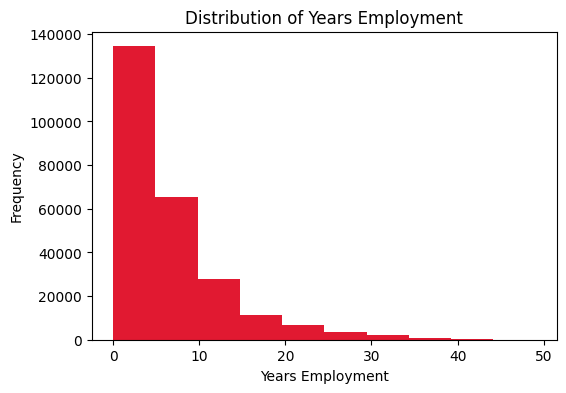

In [49]:
main.loc[main['YEARS_EMPLOYED'] >= 1000, 'YEARS_EMPLOYED'] = np.nan

plt.figure(figsize=(6, 4))
main['YEARS_EMPLOYED'].plot.hist(title = 'Distribution of Years Employment', color='#e11931')
plt.xlabel('Years Employment')
plt.show()

In [50]:
# DAYS_REGISTRATION
main['YEARS_REGISTRATION'] = abs(main['DAYS_REGISTRATION']) / 365
main.drop(columns='DAYS_REGISTRATION', inplace=True)

main['YEARS_REGISTRATION'].describe()

count    307511.000000
mean         13.660604
std           9.651743
min           0.000000
25%           5.506849
50%          12.339726
75%          20.491781
max          67.594521
Name: YEARS_REGISTRATION, dtype: float64

In [51]:
# DAYS_ID_PUBLISH
main['YEARS_ID_PUBLISH'] = abs(main['DAYS_ID_PUBLISH']) / 365
main.drop(columns='DAYS_ID_PUBLISH', inplace=True)

main['YEARS_ID_PUBLISH'].describe()

count    307511.000000
mean          8.203294
std           4.135481
min           0.000000
25%           4.712329
50%           8.915068
75%          11.778082
max          19.717808
Name: YEARS_ID_PUBLISH, dtype: float64

#### testing

Tabel testing perlu diperlakukan sama dengan tabel training, sehingga akan dilakukan penyesuaian juga untuk tabel testing

In [52]:
main_test['CODE_GENDER'].replace("XNA", np.nan, inplace=True)
main_test['ORGANIZATION_TYPE'].replace("XNA", np.nan, inplace=True)

In [53]:
# DAYS EMPLOYED
main_test['YEARS_EMPLOYED'] = abs(main_test['DAYS_EMPLOYED']) / 365
main_test.drop(columns='DAYS_EMPLOYED', inplace=True)

main_test['YEARS_EMPLOYED'].describe()

count    48744.000000
mean       195.880545
std        390.149104
min          0.002740
25%          2.871233
50%          6.663014
75%         16.895890
max       1000.665753
Name: YEARS_EMPLOYED, dtype: float64

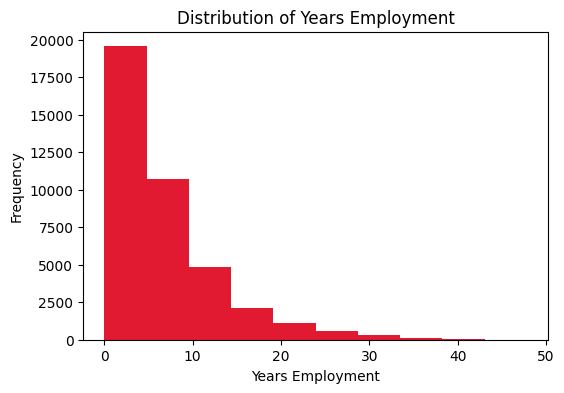

In [54]:
main_test.loc[main_test['YEARS_EMPLOYED'] >= 1000, 'YEARS_EMPLOYED'] = np.nan

plt.figure(figsize=(6, 4))
main_test['YEARS_EMPLOYED'].plot.hist(title = 'Distribution of Years Employment', color='#e11931')
plt.xlabel('Years Employment')
plt.show()

In [55]:
# DAYS_REGISTRATION
main_test['YEARS_REGISTRATION'] = abs(main_test['DAYS_REGISTRATION']) / 365
main_test.drop(columns='DAYS_REGISTRATION', inplace=True)

main_test['YEARS_REGISTRATION'].describe()

count    48744.000000
mean        13.610007
std          9.733184
min          0.000000
25%          5.208219
50%         12.301370
75%         20.436301
max         64.991781
Name: YEARS_REGISTRATION, dtype: float64

In [56]:
# DAYS_ID_PUBLISH
main_test['YEARS_ID_PUBLISH'] = abs(main_test['DAYS_ID_PUBLISH']) / 365
main_test.drop(columns='DAYS_ID_PUBLISH', inplace=True)

main_test['YEARS_ID_PUBLISH'].describe()

count    48744.000000
mean         8.360857
std          4.299388
min          0.000000
25%          4.673973
50%          8.860274
75%         12.186301
max         17.391781
Name: YEARS_ID_PUBLISH, dtype: float64

### Handling Missing Values

#### training

In [57]:
main.shape

(307511, 125)

In [58]:
miss_val = main.isnull().sum().sort_values(ascending=False).round(2)
misval_percent = round(miss_val / len(main) * 100, 3)
misval_table = pd.concat([miss_val, misval_percent], axis=1, keys=['Total', 'Percent(%)']).reset_index()
misval_table[misval_table['Percent(%)'] >= 60 ]

,index,Total,Percent(%)
0,COMMONAREA_MEDI,214865,69.872
1,COMMONAREA_AVG,214865,69.872
2,COMMONAREA_MODE,214865,69.872
3,NONLIVINGAPARTMENTS_MEDI,213514,69.433
4,NONLIVINGAPARTMENTS_AVG,213514,69.433
5,NONLIVINGAPARTMENTS_MODE,213514,69.433
6,FONDKAPREMONT_MODE,210295,68.386
7,LIVINGAPARTMENTS_MODE,210199,68.355
8,LIVINGAPARTMENTS_MEDI,210199,68.355
9,LIVINGAPARTMENTS_AVG,210199,68.355


In [59]:
main.drop(columns=list(misval_table['index'].loc[misval_table['Percent(%)'] >60]),inplace=True)
main.shape

(307511, 108)

In [60]:
null = main.isnull().sum().reset_index()
null_table = null.loc[null[0] > 0]
print('Jumlah kolom yang memiliki missing value : ', null_table.shape[0])

Jumlah kolom yang memiliki missing value :  55


In [61]:
kolom_null = main[null_table['index'].tolist()]
kolom_null.sample(5)

,CODE_GENDER,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,...,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU,YEARS_EMPLOYED
58417,F,22324.5,225000.0,Family,NaN,1.0,NaN,NaN,0.435762,0.777659,...,-2.0,0.0,0.0,0.0,0.0,3.0,0.0,7.0,4.0,NaN
250385,M,28611.0,526500.0,Unaccompanied,Managers,2.0,Transport: type 4,NaN,0.694282,0.463275,...,-1693.0,0.0,0.0,0.0,0.0,0.0,2.0,6.0,3.0,13.660274
147322,M,9000.0,180000.0,Family,High skill tech staff,1.0,Other,0.228271,0.585094,0.447179,...,-800.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.586301
233122,F,11385.0,90000.0,Unaccompanied,Realty agents,1.0,Other,0.764217,0.525657,0.248536,...,-1466.0,0.0,0.0,0.0,0.0,0.0,3.0,10.0,6.0,14.476712
54145,F,11101.5,90000.0,Unaccompanied,Cooking staff,3.0,Self-employed,0.505499,0.600774,NaN,...,-533.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,3.931507


In [62]:
print('Kolom yang memiliki null value ')
print('Numerik : ',kolom_null.select_dtypes(exclude = ["object"] ).shape[1])
print('Object : ',kolom_null.select_dtypes(include = ["object"] ).shape[1])

Kolom yang memiliki null value 
Numerik :  48
Object :  7


In [63]:
#  Handling numerical features missing value
def imputation_numeric(df):
  numerical_features = df.select_dtypes(exclude='object').columns

  for num in numerical_features:
    df[num] = df[num].fillna(df[num].median())
  return df

def imputation_categoric(df):
  categorical_features = df.select_dtypes(include='object').columns

  for cat in categorical_features:
    df[cat] = df[cat].fillna(df[cat].mode()[0])
  return df

def transform_imputation(df):
  df = imputation_numeric(df)
  df = imputation_categoric(df)
  return df

main = transform_imputation(main)
main.sample(5)

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,TOTAL_PREV_APP,TOTAL_BUREAU,OCCUPATION_TYPE_NEW_CAT,Age_years,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH
104021,220719,0,Cash loans,M,N,N,0,117000.0,263686.5,28107.0,...,0.0,0.0,1.0,2.0,4.0,Service Level,23.326027,0.460274,9.263014,3.230137
232014,368737,0,Revolving loans,F,N,N,0,126000.0,270000.0,13500.0,...,0.0,0.0,5.0,5.0,6.0,Management Level,41.764384,1.008219,17.183562,4.545205
11984,113973,0,Cash loans,M,N,Y,0,54000.0,225000.0,9909.0,...,0.0,0.0,0.0,4.0,1.0,NaN,64.279452,4.515068,0.142466,13.290411
41223,147729,0,Cash loans,F,Y,Y,1,135000.0,67765.5,7245.0,...,1.0,0.0,0.0,2.0,7.0,NaN,40.295890,2.621918,21.602740,11.550685
185308,314811,0,Cash loans,M,N,Y,0,135000.0,269550.0,21739.5,...,0.0,0.0,1.0,12.0,6.0,Management Level,31.728767,1.364384,0.284932,8.739726


Saat mengelompokkan pekerjaan masih terdapat missing value pada kolom `OCCUPATION_TYPE`, sehingga hasilnya mempengaruhi kelompok pekerjaan. Karena sekarang sudah tidak ada missing value pada kolom `OCCUPATION_TYPE`, kita akan coba kelompokkan kembali agar tidak ada yang memiliki hasil NaN

In [64]:
main['OCCUPATION_TYPE_NEW_CAT'] = main['OCCUPATION_TYPE'].apply(occupation_group)

In [65]:
sum(main.isna().sum())

0

Tidak ada missing value

#### testing

In [66]:
main_test.shape

(48744, 122)

In [67]:
miss_val = main_test.isnull().sum().sort_values(ascending=False).round(2)
misval_percent = round(miss_val / len(main_test) * 100, 3)
misval_table = pd.concat([miss_val, misval_percent], axis=1, keys=['Total', 'Percent(%)']).reset_index()

main_test.drop(columns=list(misval_table['index'].loc[misval_table['Percent(%)'] >60]),inplace=True)
main_test.shape

(48744, 105)

In [68]:
main_test = transform_imputation(main_test)
main_test.sample(5)

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,OCCUPATION_TYPE_NEW_CAT,Age_years,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH
30066,318769,Cash loans,F,N,Y,2,135000.0,817560.0,30951.0,675000.0,...,0.0,0.0,0.0,0.0,2.0,Service Level,33.605479,2.750685,0.682192,4.208219
41237,402953,Cash loans,F,Y,Y,0,180000.0,512446.5,40617.0,463500.0,...,0.0,0.0,0.0,0.0,2.0,Staff Level,44.060274,7.671233,22.909589,11.942466
14451,204196,Cash loans,M,N,Y,0,90000.0,360000.0,28570.5,360000.0,...,0.0,0.0,0.0,0.0,2.0,Service Level,24.454795,2.879452,9.843836,4.400000
15660,212963,Cash loans,M,Y,N,0,157500.0,533709.0,29083.5,445500.0,...,0.0,0.0,0.0,1.0,1.0,Service Level,25.978082,6.386301,11.128767,5.838356
32072,333566,Cash loans,M,N,N,1,112500.0,900000.0,46084.5,900000.0,...,0.0,0.0,0.0,1.0,2.0,NaN,38.136986,2.509589,20.947945,11.972603


In [69]:
main_test['OCCUPATION_TYPE_NEW_CAT'] = main_test['OCCUPATION_TYPE'].apply(occupation_group)

In [70]:
sum(main_test.isna().sum())

0

### Feature Encoding

In [71]:
main.drop(columns='OCCUPATION_TYPE', inplace=True)

In [72]:
main_test.drop(columns='OCCUPATION_TYPE', inplace=True)

In [73]:
main.select_dtypes(include='object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             57
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
OCCUPATION_TYPE_NEW_CAT        3
dtype: int64

In [74]:
main.drop(columns='ORGANIZATION_TYPE', inplace=True)

In [75]:
main_test.drop(columns='ORGANIZATION_TYPE', inplace=True)

In [76]:
columns = main.select_dtypes(include='object').columns.tolist()

main = pd.get_dummies(main, columns=columns, drop_first=True)
main.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,OCCUPATION_TYPE_NEW_CAT_Service Level,OCCUPATION_TYPE_NEW_CAT_Staff Level
0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,1,1,...,0,0,0,0,0,1,0,0,1,0
1,100003,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,1,1,...,0,0,0,0,0,0,0,0,0,1
2,100004,0,0,67500.0,135000.0,6750.0,135000.0,0.010032,1,1,...,0,0,0,0,1,0,0,0,1,0
3,100006,0,0,135000.0,312682.5,29686.5,297000.0,0.008019,1,1,...,0,0,0,0,1,0,0,0,1,0
4,100007,0,0,121500.0,513000.0,21865.5,513000.0,0.028663,1,1,...,0,0,0,0,1,0,0,0,0,1


In [77]:
main.shape

(307511, 140)

In [78]:
columns = main_test.select_dtypes(include='object').columns.tolist()

main_test = pd.get_dummies(main_test, columns=columns, drop_first=True)
main_test.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,OCCUPATION_TYPE_NEW_CAT_Service Level,OCCUPATION_TYPE_NEW_CAT_Staff Level
0,100001,0,135000.0,568800.0,20560.5,450000.0,0.018850,1,1,0,...,0,0,0,0,0,1,0,0,1,0
1,100005,0,99000.0,222768.0,17370.0,180000.0,0.035792,1,1,0,...,0,0,0,0,1,0,0,0,1,0
2,100013,0,202500.0,663264.0,69777.0,630000.0,0.019101,1,1,0,...,0,0,0,0,1,0,0,0,1,0
3,100028,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,1,1,0,...,0,0,0,0,1,0,0,0,0,1
4,100038,1,180000.0,625500.0,32067.0,625500.0,0.010032,1,1,1,...,0,0,0,0,1,0,0,0,1,0


In [79]:
main_test.shape

(48744, 135)

### Feature Selection

Feature selection atau pemilhan fitur akan dilakukan berdasarkan :
1. Correlation with Target
2. Uji chi-square untuk kolom kategori

#### training

In [80]:
# Membuat tabel nilai korelasi berdarkan value corr terbesar
corr = main.corrwith(main["TARGET"])
corr = corr.reset_index(name='corr value')
corr["Corr type"] = corr["corr value"].apply(lambda x : "Positif" if x >= 0 else "Negatif")
corr["corr value"] = corr["corr value"].apply(lambda x : abs(x))
corr_sort = corr.sort_values('corr value', ascending=False)
feature_select = corr_sort.head(30)

In [81]:
feature_select

,index,corr value,Corr type
1,TARGET,1.000000,Positif
25,EXT_SOURCE_2,0.160295,Negatif
26,EXT_SOURCE_3,0.155892,Negatif
24,EXT_SOURCE_1,0.098887,Negatif
88,Age_years,0.078239,Negatif
89,YEARS_EMPLOYED,0.063368,Negatif
16,REGION_RATING_CLIENT_W_CITY,0.060893,Positif
15,REGION_RATING_CLIENT,0.058899,Positif
108,NAME_INCOME_TYPE_Working,0.057481,Positif
109,NAME_EDUCATION_TYPE_Higher education,0.056593,Negatif


In [82]:
# Buat list semua nama kolom
all_columns_cat = [
    'NAME_CONTRACT_TYPE_Revolving loans', 'CODE_GENDER_M', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y',
    'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Group of people', 'NAME_TYPE_SUITE_Other_A',
    'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Spouse, partner', 'NAME_TYPE_SUITE_Unaccompanied',
    'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_Maternity leave',
    'NAME_INCOME_TYPE_Pensioner', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
    'NAME_INCOME_TYPE_Unemployed', 'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher education',
    'NAME_EDUCATION_TYPE_Incomplete higher', 'NAME_EDUCATION_TYPE_Lower secondary',
    'NAME_EDUCATION_TYPE_Secondary / secondary special', 'NAME_FAMILY_STATUS_Married',
    'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Unknown',
    'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House / apartment',
    'NAME_HOUSING_TYPE_Municipal apartment', 'NAME_HOUSING_TYPE_Office apartment',
    'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents',
    'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_SATURDAY',
    'WEEKDAY_APPR_PROCESS_START_SUNDAY', 'WEEKDAY_APPR_PROCESS_START_THURSDAY',
    'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'WEEKDAY_APPR_PROCESS_START_WEDNESDAY',
    'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house',
    'WALLSMATERIAL_MODE_Mixed', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
    'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden',
    'EMERGENCYSTATE_MODE_Yes', 'OCCUPATION_TYPE_NEW_CAT_Service Level',
    'OCCUPATION_TYPE_NEW_CAT_Staff Level'
]

In [83]:
pd.set_option('display.float_format', '{:.5f}'.format)
chi2_array, p_array = [], []
for column in all_columns_cat:
  crosstab = pd.crosstab(main[column], main['TARGET'])
  chi2, p, dof, expected = chi2_contingency(crosstab)
  chi2_array.append(chi2)
  p_array.append(p)

chi_table = pd.DataFrame({
  'Variable': all_columns_cat,
  'Chi-square': chi2_array,
  'p-value': p_array
})

chi_table.sort_values(by='p-value')

,Variable,Chi-square,p-value
16,NAME_INCOME_TYPE_Working,1015.62079,0.00000
17,NAME_EDUCATION_TYPE_Higher education,984.38989,0.00000
1,CODE_GENDER_M,920.10385,0.00000
20,NAME_EDUCATION_TYPE_Secondary / secondary special,762.96350,0.00000
12,NAME_INCOME_TYPE_Pensioner,656.19013,0.00000
0,NAME_CONTRACT_TYPE_Revolving loans,293.15054,0.00000
30,NAME_HOUSING_TYPE_With parents,275.61726,0.00000
26,NAME_HOUSING_TYPE_House / apartment,250.40749,0.00000
23,NAME_FAMILY_STATUS_Single / not married,215.97183,0.00000
46,OCCUPATION_TYPE_NEW_CAT_Service Level,210.57334,0.00000


In [84]:
select_chi = chi_table[chi_table['p-value'] < 0.05]
select_chi

,Variable,Chi-square,p-value
0,NAME_CONTRACT_TYPE_Revolving loans,293.15054,0.00000
1,CODE_GENDER_M,920.10385,0.00000
2,FLAG_OWN_CAR_Y,146.65602,0.00000
3,FLAG_OWN_REALTY_Y,11.57583,0.00067
4,NAME_TYPE_SUITE_Family,20.72031,0.00001
7,NAME_TYPE_SUITE_Other_B,7.17444,0.00739
9,NAME_TYPE_SUITE_Unaccompanied,16.42075,0.00005
10,NAME_INCOME_TYPE_Commercial associate,43.48453,0.00000
12,NAME_INCOME_TYPE_Pensioner,656.19013,0.00000
13,NAME_INCOME_TYPE_State servant,168.71974,0.00000


In [85]:
selected_chi_square = select_chi['Variable'].tolist()
selected_features_corr = feature_select['index'].tolist()

In [86]:
# List kolom yang ada di select_chi_square tetapi tidak ada di select_features_corr
not_in_features_corr = [col for col in selected_chi_square if col not in selected_features_corr]

# Cetak list kolom yang tidak ada di select_features_corr
print("Kolom yang tidak ada di select_features_corr:")
print(not_in_features_corr)

Kolom yang tidak ada di select_features_corr:
['NAME_CONTRACT_TYPE_Revolving loans', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y', 'NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Other_B', 'NAME_TYPE_SUITE_Unaccompanied', 'NAME_INCOME_TYPE_Commercial associate', 'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Unemployed', 'NAME_EDUCATION_TYPE_Lower secondary', 'NAME_FAMILY_STATUS_Married', 'NAME_FAMILY_STATUS_Single / not married', 'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House / apartment', 'NAME_HOUSING_TYPE_Office apartment', 'NAME_HOUSING_TYPE_Rented apartment', 'NAME_HOUSING_TYPE_With parents', 'WEEKDAY_APPR_PROCESS_START_MONDAY', 'WEEKDAY_APPR_PROCESS_START_TUESDAY', 'HOUSETYPE_MODE_specific housing', 'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick', 'WALLSMATERIAL_MODE_Wooden', 'EMERGENCYSTATE_MODE_Yes', 'OCCUPATION_TYPE_NEW_CAT_Service Level', 'OCCUPATION_TYPE_NEW_CAT_Staff Level']


In [87]:
# Menggabungkan list kolom hasil feature selection
selected_features = selected_features_corr + not_in_features_corr

# Buat DataFrame baru hanya dengan kolom-kolom yang dipilih
df = main[selected_features]

# Cetak beberapa baris pertama dari data baru
df.head()

,TARGET,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,Age_years,YEARS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,...,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,HOUSETYPE_MODE_specific housing,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,OCCUPATION_TYPE_NEW_CAT_Service Level,OCCUPATION_TYPE_NEW_CAT_Staff Level
0,1,0.26295,0.13938,0.08304,25.92055,1.74521,2,2,1,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0.62225,0.53528,0.31127,45.93151,3.25479,1,1,0,1,...,1,0,0,0,0,0,0,0,0,1
2,0,0.55591,0.72957,0.50600,52.18082,0.61644,2,2,1,0,...,1,0,0,0,1,0,0,0,1,0
3,0,0.65044,0.53528,0.50600,52.06849,8.32603,2,2,1,0,...,0,0,0,0,1,0,0,0,1,0
4,0,0.32274,0.53528,0.50600,54.60822,8.32329,2,2,1,0,...,0,0,0,0,1,0,0,0,0,1


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 0 to 307510
Data columns (total 57 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   TARGET                                             307511 non-null  int64  
 1   EXT_SOURCE_2                                       307511 non-null  float64
 2   EXT_SOURCE_3                                       307511 non-null  float64
 3   EXT_SOURCE_1                                       307511 non-null  float64
 4   Age_years                                          307511 non-null  float64
 5   YEARS_EMPLOYED                                     307511 non-null  float64
 6   REGION_RATING_CLIENT_W_CITY                        307511 non-null  int64  
 7   REGION_RATING_CLIENT                               307511 non-null  int64  
 8   NAME_INCOME_TYPE_Working                           307511 non-null  uint8 

In [89]:
# Mengambil nilai korelasi absolut di atas 0.8
df_corr = df.corr()
high_corr_pairs = (df_corr.abs().stack() > 0.8) & (df_corr.abs().stack() < 1.0)

# Menampilkan pasangan kolom dengan korelasi tinggi (unik)
high_corr_columns = set(
    tuple(sorted(pair)) for pair in high_corr_pairs[high_corr_pairs].index.tolist()
)

# Menampilkan hasil
print("Pasangan kolom dengan korelasi di atas 0.8:")
for pair in high_corr_columns:
    print(pair)

Pasangan kolom dengan korelasi di atas 0.8:
('REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY')
('NAME_TYPE_SUITE_Family', 'NAME_TYPE_SUITE_Unaccompanied')
('ELEVATORS_AVG', 'ELEVATORS_MODE')
('FLOORSMAX_MEDI', 'FLOORSMAX_MODE')
('FLOORSMAX_AVG', 'FLOORSMAX_MEDI')
('FLAG_EMP_PHONE', 'NAME_INCOME_TYPE_Pensioner')
('FLOORSMAX_AVG', 'FLOORSMAX_MODE')
('ELEVATORS_MEDI', 'ELEVATORS_MODE')
('WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick')
('LIVE_CITY_NOT_WORK_CITY', 'REG_CITY_NOT_WORK_CITY')
('ELEVATORS_AVG', 'ELEVATORS_MEDI')
('NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Secondary / secondary special')


Untuk menghindari multikolinearitas, kolom yang memiliki relasi di atas 0.8 dan menyimpan informasi yang serupa atau memiliki makna yang mirip akan di drop salah satunya.

In [90]:
columns_to_drop = ['ELEVATORS_MEDI', 'LIVE_CITY_NOT_WORK_CITY','REGION_RATING_CLIENT', 'ELEVATORS_MODE', 'ELEVATORS_MODE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI']
df = df.drop(columns=columns_to_drop)

In [91]:
df.shape

(307511, 51)

#### testing

In [92]:
# Hapus 'TARGET' dari selected_features untuk dataframe test
selected_features_test = [feature for feature in selected_features if feature != 'TARGET']

df_test = main_test[selected_features_test]
df_test.head(5)

,EXT_SOURCE_2,EXT_SOURCE_3,EXT_SOURCE_1,Age_years,YEARS_EMPLOYED,REGION_RATING_CLIENT_W_CITY,REGION_RATING_CLIENT,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,DAYS_LAST_PHONE_CHANGE,...,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,HOUSETYPE_MODE_specific housing,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_Yes,OCCUPATION_TYPE_NEW_CAT_Service Level,OCCUPATION_TYPE_NEW_CAT_Staff Level
0,0.78965,0.15952,0.75261,52.71507,6.38082,2,2,1,1,-1740.00000,...,0,1,0,0,0,1,0,0,1,0
1,0.29166,0.43296,0.56499,49.49041,12.24384,2,2,1,0,0.00000,...,0,0,0,0,1,0,0,0,1,0
2,0.69979,0.61099,0.50677,54.89863,12.21370,2,2,1,1,-856.00000,...,1,0,0,0,1,0,0,0,1,0
3,0.50968,0.61270,0.52573,38.29041,5.11233,2,2,1,0,-1805.00000,...,0,0,0,0,1,0,0,0,0,1
4,0.42569,0.51910,0.20214,35.72603,6.00274,2,2,1,0,-821.00000,...,0,0,0,0,1,0,0,0,1,0


In [93]:
columns_to_drop = ['ELEVATORS_MEDI', 'LIVE_CITY_NOT_WORK_CITY','REGION_RATING_CLIENT', 'ELEVATORS_MODE', 'ELEVATORS_MODE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI']
df_test = df_test.drop(columns=columns_to_drop)

In [94]:
df_test.shape

(48744, 50)

### Pemisahan fitur dan target

In [95]:
X = df.drop(columns=['TARGET'], axis=1) #features
y = df['TARGET'] #label

In [96]:
print(X.shape)
print(y.shape)

(307511, 50)
(307511,)


### Handling Class Imbalance

In [97]:
smote = SMOTE(random_state=0)

# Resample dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Print distribusi kelas sebelum dan sesudah resample
print("Original Class Distribution:")
print(y.value_counts())

print("\nClass Distribution After Resampling:")
print(pd.Series(y_resampled).value_counts())

Original Class Distribution:
0    282686
1     24825
Name: TARGET, dtype: int64

Class Distribution After Resampling:
1    282686
0    282686
Name: TARGET, dtype: int64


### Split Data

In [98]:
x_train, x_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 0)

In [99]:
print('feature: ', x_train.shape, x_test.shape)
print('label: ', y_train.shape, y_test.shape)

feature:  (395760, 50) (169612, 50)
label:  (395760,) (169612,)


### Feature Transformation

In [100]:
scaler = StandardScaler()

X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)

## **Modeling**

In [101]:
def eval_classification(model):
  y_pred = model.predict(x_test)
  y_pred_train = model.predict(x_train)
  y_pred_proba = model.predict_proba(x_test)
  y_pred_proba_train = model.predict_proba(x_train)

  print("Accuracy (train): %.2f" % accuracy_score(y_train, y_pred_train))
  print("Precision (train): %.2f" % precision_score(y_train, y_pred_train))
  print("Recall (train): %.2f" % recall_score(y_train, y_pred_train))
  print("F1-Score (train): %.2f" % f1_score(y_train, y_pred_train))

  print("\nAccuracy (Test): %.2f" % accuracy_score(y_test, y_pred))
  print("Precision (Test): %.2f" % precision_score(y_test, y_pred))
  print("Recall (Test): %.2f" % recall_score(y_test, y_pred))
  print("F1-Score (Test): %.2f" % f1_score(y_test, y_pred))

  print("\nroc_auc (train-proba): %.2f" % roc_auc_score(y_train, y_pred_proba_train[:, 1]))
  print("roc_auc (test-proba): %.2f" % roc_auc_score(y_test, y_pred_proba[:, 1]))

def cv_score(model):
  score = cross_validate(model, X, y, cv=5, scoring='roc_auc', return_train_score=True)
  print('\nroc_auc (crossval train): '+ str(score['train_score'].mean()))
  print('roc_auc (crossval test): '+ str(score['test_score'].mean()))

def show_feature_importance(model):
  feat_importances = pd.Series(model.feature_importances_, index=X.columns)
  ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8), color='#e11931')
  ax.invert_yaxis()

  plt.xlabel('Score')
  plt.ylabel('Features')
  plt.title('Features Importance')

In [102]:
def show_best_hyperparameter(model):
  # print('Best Model')
  # print(model.best_estimator_)
  print('Best Params')
  print(model.best_params_)
  print('\nBest ROC AUC Score')
  print(model.best_score_)

#### Logistic Regression

##### Fit Model

In [103]:
logit = LogisticRegression()
logit.fit(x_train, y_train)

LogisticRegression()

In [104]:
eval_classification(logit)

Accuracy (train): 0.51
Precision (train): 0.53
Recall (train): 0.21
F1-Score (train): 0.30

Accuracy (Test): 0.51
Precision (Test): 0.54
Recall (Test): 0.21
F1-Score (Test): 0.30

roc_auc (train-proba): 0.55
roc_auc (test-proba): 0.55


##### Hyperparameter Tuninng

In [105]:
# Mendefinisikan hyperparamter
penalty = ['l2']
C = [float(x) for x in np.linspace(0.0001, 0.05, 100)]
hyperparameters = dict(penalty=penalty, C=C)

logit = LogisticRegression(random_state=0, solver='lbfgs')

# Use RandomizedSearchCV for hyperparameter tuning
rs_logit = RandomizedSearchCV(logit, hyperparameters, scoring='roc_auc', random_state=0, cv=5, n_iter=30, error_score='raise')
rs_logit.fit(x_train, y_train)

show_best_hyperparameter(rs_logit)

Best Params
{'penalty': 'l2', 'C': 0.0011080808080808082}

Best ROC AUC Score
0.5527431628923762


In [106]:
print('Best Model')
print(rs_logit.best_estimator_)

Best Model
LogisticRegression(C=0.0011080808080808082, random_state=0)


In [107]:
best_logit = rs_logit.best_estimator_
best_logit.fit(x_train, y_train)
eval_classification(best_logit)

Accuracy (train): 0.51
Precision (train): 0.53
Recall (train): 0.21
F1-Score (train): 0.30

Accuracy (Test): 0.51
Precision (Test): 0.54
Recall (Test): 0.21
F1-Score (Test): 0.30

roc_auc (train-proba): 0.55
roc_auc (test-proba): 0.55


#### Decision Tree

##### Fit Model

In [108]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier()

In [109]:
eval_classification(dt)

Accuracy (train): 1.00
Precision (train): 1.00
Recall (train): 1.00
F1-Score (train): 1.00

Accuracy (Test): 0.88
Precision (Test): 0.87
Recall (Test): 0.89
F1-Score (Test): 0.88

roc_auc (train-proba): 1.00
roc_auc (test-proba): 0.88


##### Hyperparameter Tuning

In [110]:
dt = DecisionTreeClassifier(random_state=0)

# Mendefinisikan hyperparameter
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10, 20, 50],
    'max_features': ['auto', 'sqrt']
}

# RandomizedSearchCV untuk mencari hyperparameter terbaik
rs_dt = RandomizedSearchCV(dt, param_distributions=param_dist, n_iter=30, scoring='roc_auc', random_state=0, cv=5)
rs_dt.fit(x_train, y_train)

show_best_hyperparameter(rs_dt)

Best Params
{'min_samples_split': 5, 'min_samples_leaf': 20, 'max_features': 'sqrt', 'max_depth': 50, 'criterion': 'entropy'}

Best ROC AUC Score
0.9315128115938226


In [111]:
best_dt = rs_dt.best_estimator_
best_dt.fit(x_train, y_train)
eval_classification(best_dt)

Accuracy (train): 0.89
Precision (train): 0.92
Recall (train): 0.86
F1-Score (train): 0.89

Accuracy (Test): 0.87
Precision (Test): 0.90
Recall (Test): 0.84
F1-Score (Test): 0.87

roc_auc (train-proba): 0.96
roc_auc (test-proba): 0.93


#### LightBGM

##### Fit Model

In [112]:
# Membuat salinan dari DataFrame untuk menghindari perubahan pada DataFrame asli
x_train_lgbm = x_train.copy()

# Mengganti karakter khusus dan spasi dalam nama kolom
x_train_lgbm.columns = x_train_lgbm.columns.to_series().apply(lambda x: re.sub('[^a-zA-Z0-9]', '_', x))

In [113]:
lgbm = LGBMClassifier()
lgbm.fit(x_train_lgbm, y_train)

[LightGBM] [Info] Number of positive: 197681, number of negative: 198079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.123494 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3382
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499497 -> initscore=-0.002011
[LightGBM] [Info] Start training from score -0.002011


LGBMClassifier()

In [114]:
eval_classification(lgbm)

Accuracy (train): 0.94
Precision (train): 0.98
Recall (train): 0.91
F1-Score (train): 0.94

Accuracy (Test): 0.94
Precision (Test): 0.98
Recall (Test): 0.90
F1-Score (Test): 0.94

roc_auc (train-proba): 0.97
roc_auc (test-proba): 0.97


##### Hyperparameter Tuning

In [115]:
lgbm = LGBMClassifier(random_state=0)

# Mendefinisikan rentang hyperparameter
param_dist = {
    'num_leaves': sp_randint(6, 20),
    'max_depth': sp_randint(3, 15),
    'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3],
    'n_estimators': sp_randint(50, 100),
}

# RandomizedSearchCV
rs_lgbm = RandomizedSearchCV(lgbm, param_distributions=param_dist, n_iter=30, scoring='roc_auc', cv=5, random_state=0, n_jobs=-1)

# Lakukan hyperparameter tuning pada data train
rs_lgbm.fit(x_train_lgbm, y_train)

show_best_hyperparameter(rs_lgbm)

[LightGBM] [Info] Number of positive: 197681, number of negative: 198079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.221578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3384
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499497 -> initscore=-0.002011
[LightGBM] [Info] Start training from score -0.002011
Best Params
{'learning_rate': 0.2, 'max_depth': 13, 'n_estimators': 73, 'num_leaves': 19}

Best ROC AUC Score
0.9717282556439024


In [116]:
print('Best Model')
print(rs_lgbm.best_estimator_)

Best Model
LGBMClassifier(learning_rate=0.2, max_depth=13, n_estimators=73, num_leaves=19,
               random_state=0)


In [117]:
best_lgbm = rs_lgbm.best_estimator_
best_lgbm.fit(x_train_lgbm, y_train)
eval_classification(best_lgbm)

[LightGBM] [Info] Number of positive: 197681, number of negative: 198079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.176397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3384
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499497 -> initscore=-0.002011
[LightGBM] [Info] Start training from score -0.002011
Accuracy (train): 0.94
Precision (train): 0.98
Recall (train): 0.91
F1-Score (train): 0.94

Accuracy (Test): 0.94
Precision (Test): 0.98
Recall (Test): 0.90
F1-Score (Test): 0.94

roc_auc (train-proba): 0.97
roc_auc (test-proba): 0.97


#### Model Evaluation

In [118]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [119]:
# Anda punya tiga model: logit, dt, dan lgbm
models = [logit.fit(x_train, y_train), dt.fit(x_train, y_train), lgbm.fit(x_train_lgbm, y_train)]

# Membuat DataFrame untuk menampung hasil evaluasi model
model_eval = pd.DataFrame({'Models': ['Logistic Regression', 'Decision Tree', 'LightGBM'],
                            'roc_auc (test)': [roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]) for model in models],
                            'roc_auc (train)': [roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]) for model in models],
                            'Accuracy (test)': [accuracy_score(y_test, model.predict(x_test)) for model in models],
                            'Accuracy (train)': [accuracy_score(y_train, model.predict(x_train)) for model in models],
                            'Precision (test)': [precision_score(y_test, model.predict(x_test)) for model in models],
                            'Precision (train)': [precision_score(y_train, model.predict(x_train)) for model in models],
                            'Recall (test)': [recall_score(y_test, model.predict(x_test)) for model in models],
                            'Recall (train)': [recall_score(y_train, model.predict(x_train)) for model in models],
                            'F1 Score (test)': [f1_score(y_test, model.predict(x_test)) for model in models],
                            'F1 Score (train)': [f1_score(y_train, model.predict(x_train)) for model in models],
                           })

# Menampilkan hasil evaluasi model
model_eval

[LightGBM] [Info] Number of positive: 197681, number of negative: 198079
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.173827 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3384
[LightGBM] [Info] Number of data points in the train set: 395760, number of used features: 49
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499497 -> initscore=-0.002011
[LightGBM] [Info] Start training from score -0.002011


,Models,roc_auc (test),roc_auc (train),Accuracy (test),Accuracy (train),Precision (test),Precision (train),Recall (test),Recall (train),F1 Score (test),F1 Score (train)
0,Logistic Regression,0.55,0.55,0.51,0.51,0.54,0.53,0.21,0.21,0.30,0.30
1,Decision Tree,0.88,1.00,0.88,1.00,0.87,1.00,0.89,1.00,0.88,1.00
2,LightGBM,0.97,0.97,0.94,0.94,0.98,0.98,0.90,0.91,0.94,0.94


After Hyperparameter Tuning

In [120]:
# Anda punya tiga model: logit, dt, dan lgbm
models_tuning = [best_logit, best_dt, best_lgbm]

# Membuat DataFrame untuk menampung hasil evaluasi model
model_eval_tuning = pd.DataFrame({'Models': ['Logistic Regression', 'Decision Tree', 'LightGBM'],
                            'roc_auc (test)': [roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]) for model in models_tuning],
                            'roc_auc (train)': [roc_auc_score(y_train, model.predict_proba(x_train)[:, 1]) for model in models_tuning],
                            'Accuracy (test)': [accuracy_score(y_test, model.predict(x_test)) for model in models_tuning],
                            'Accuracy (train)': [accuracy_score(y_train, model.predict(x_train)) for model in models_tuning],
                            'Precision (test)': [precision_score(y_test, model.predict(x_test)) for model in models_tuning],
                            'Precision (train)': [precision_score(y_train, model.predict(x_train)) for model in models_tuning],
                            'Recall (test)': [recall_score(y_test, model.predict(x_test)) for model in models_tuning],
                            'Recall (train)': [recall_score(y_train, model.predict(x_train)) for model in models_tuning],
                            'F1 Score (test)': [f1_score(y_test, model.predict(x_test)) for model in models_tuning],
                            'F1 Score (train)': [f1_score(y_train, model.predict(x_train)) for model in models_tuning],
                           })

# Menampilkan hasil evaluasi model
model_eval_tuning

,Models,roc_auc (test),roc_auc (train),Accuracy (test),Accuracy (train),Precision (test),Precision (train),Recall (test),Recall (train),F1 Score (test),F1 Score (train)
0,Logistic Regression,0.55,0.55,0.51,0.51,0.54,0.53,0.21,0.21,0.30,0.30
1,Decision Tree,0.93,0.96,0.87,0.89,0.90,0.92,0.84,0.86,0.87,0.89
2,LightGBM,0.97,0.97,0.94,0.94,0.98,0.98,0.90,0.91,0.94,0.94


Berdasarkan percobaan pemodelan yang telah dilakukan, model **LightBGMClassifier** dipilih menjadi model yang akan digunakan untuk memprediksi apakah customer tersebut mampu melakukan pelunasan pinjaman atau tidak.

## **Feature Importance**

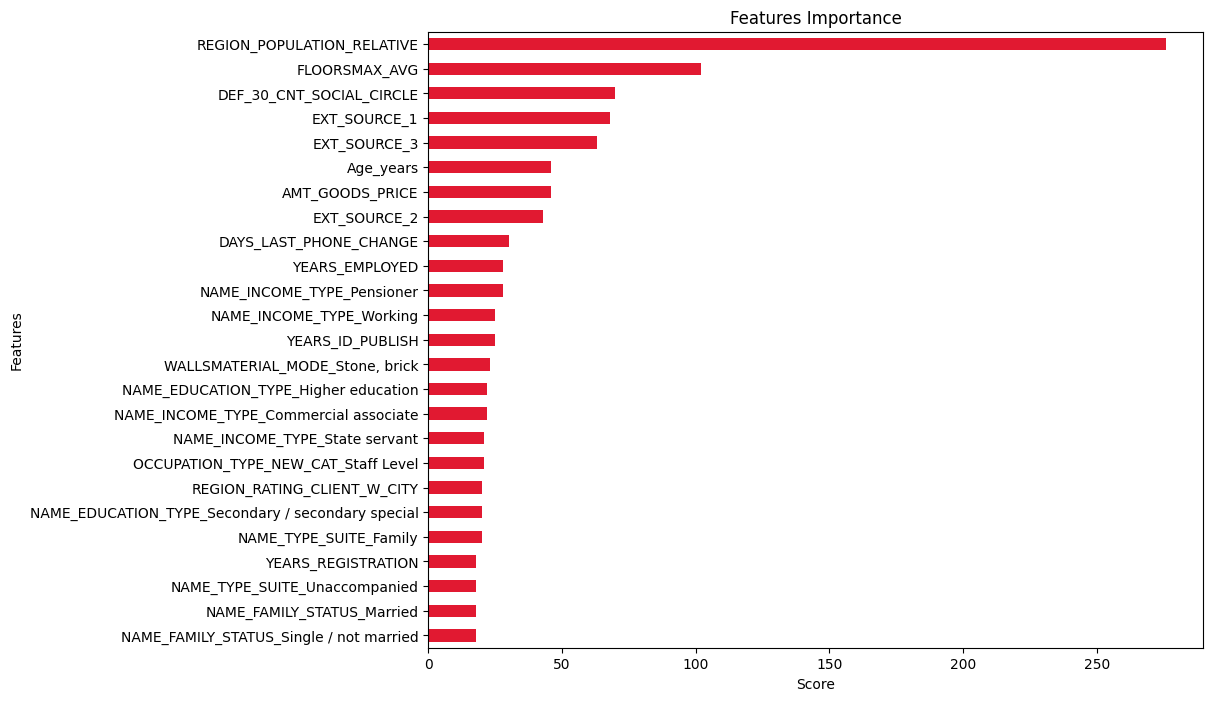

In [121]:
show_feature_importance(best_lgbm)

In [122]:
feature_importances = best_lgbm.feature_importances_

# Pair feature names with their importances
feature_names = X_resampled.columns.tolist()
feature_importance_dict = dict(zip(feature_names, feature_importances))

# Sort feature importances in descending order
sorted_feature_importance = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print the feature importances
for feature, importance in sorted_feature_importance:
    print(f"{feature}: {importance:.2f}")

REGION_POPULATION_RELATIVE: 276.00
FLOORSMAX_AVG: 102.00
DEF_30_CNT_SOCIAL_CIRCLE: 70.00
EXT_SOURCE_1: 68.00
EXT_SOURCE_3: 63.00
Age_years: 46.00
AMT_GOODS_PRICE: 46.00
EXT_SOURCE_2: 43.00
DAYS_LAST_PHONE_CHANGE: 30.00
YEARS_EMPLOYED: 28.00
NAME_INCOME_TYPE_Pensioner: 28.00
NAME_INCOME_TYPE_Working: 25.00
YEARS_ID_PUBLISH: 25.00
WALLSMATERIAL_MODE_Stone, brick: 23.00
NAME_EDUCATION_TYPE_Higher education: 22.00
NAME_INCOME_TYPE_Commercial associate: 22.00
NAME_INCOME_TYPE_State servant: 21.00
OCCUPATION_TYPE_NEW_CAT_Staff Level: 21.00
REGION_RATING_CLIENT_W_CITY: 20.00
NAME_EDUCATION_TYPE_Secondary / secondary special: 20.00
NAME_TYPE_SUITE_Family: 20.00
YEARS_REGISTRATION: 18.00
NAME_TYPE_SUITE_Unaccompanied: 18.00
NAME_FAMILY_STATUS_Married: 18.00
NAME_FAMILY_STATUS_Single / not married: 18.00
OCCUPATION_TYPE_NEW_CAT_Service Level: 18.00
WALLSMATERIAL_MODE_Panel: 17.00
ELEVATORS_AVG: 15.00
FLAG_OWN_CAR_Y: 15.00
NAME_CONTRACT_TYPE_Revolving loans: 14.00
NAME_HOUSING_TYPE_House / apartm

**Top 10 Feature Importance**

Berdasarkan Feature Importance model LightGBM Classifier, didapatkan bahwa :
1. Feauture paling penting adalah REGION_POPULATION_RELATIVE. Hal ini menunjukkan bahwa **kepadatan populasi wilayah tempat client tinggal** memiliki pengaruh yang besar terhadap prediksi kemampuan client melakukan pelunasan pinjaman.
2. Feature importance yang kedua adalah FLOORSMAX_AVG, ini berarti nilai **rata-rata tingkat lantai maksimum di bangunan tempat client tinggal** memiliki pengaruh besar pada prediksi.
3. Feature DEF_30_CNT_SOCIAL_CIRCLE, ini berarti **jumlah keterlambatan pembayaran lebih dari 30 hari dalam lingkaran sosial pelanggan** meerupakan faktor penting dalam prediksi risiko pelunasan.
4. Feature EXT_SOURCE_1, ini menandakan bahwa **skor sumber eksternal 1 (skor kredit dari sumber eksternal)** memiliki pengaruh besar pada prediksi. Nilai EXT_SOURCE_1 yang tinggi menunjukkan kemungkinan besar client mampu melakukan pelunasan pinjaman.
5. Feature EXT_SOURCE_3, di mana **skor sumber eksternal 3** memiliki pengaruh besar pada prediksi. Nilai EXT_SOURCE_3 yang tinggi dapat mengindikasikan bahwa client mampu melakkan pelunasan pinjaman.
6. Feature Age_years, menunjukkan **usia client (dalam tahun)** memiliki pengaruh pada prediksi risiko pelunasan.
7. Feature AMT_GOODS_PRICE, ini berarti **harga barang** yang dibiayai memiliki dampak pada hasil prediksi.
8. Feature EXT_SOURCE_2, **skor sumber eksternal 2** memiliki dampak pada prediksi. Nilai EXT_SOURCE_2 yang rendah menunjukkan kemungkinan besar client kesulitan melakukan pelunasan.
9. Feature DAYS_LAST_PHONE_CHANGE, mengindikasikan **jumlah hari sejak perubahan terakhir nomor telepon** pelanggan memiliki dampak pada prediksi. Mungkin menunjukkan stabilitas atau perubahan situasi pelanggan.
10. Feature YEARS_EMPLOYED, ini berarti **jumlah tahun bekerja** memiliki pengaruh pada prediksi mengenai kemampuan seorang client dalam melakukan pelunasan pinjaman.



### Business Insight II

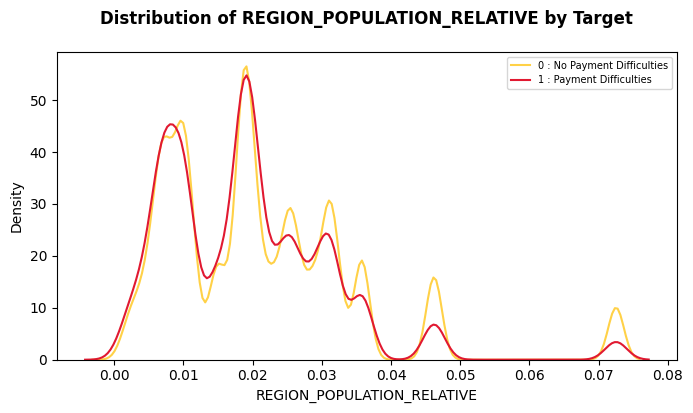

In [123]:
plt.figure(figsize=(8, 4))

sns.kdeplot(main.loc[main['TARGET'] == 0, 'REGION_POPULATION_RELATIVE'], label= '0 : No Payment Difficulties', color='#ffd147')
sns.kdeplot(main.loc[main['TARGET'] == 1, 'REGION_POPULATION_RELATIVE'], label= '1 : Payment Difficulties', color='#e11931', )
plt.title('Distribution of REGION_POPULATION_RELATIVE by Target', fontweight='bold', pad=20)
plt.xlabel('REGION_POPULATION_RELATIVE')
plt.ylabel('Density')
plt.legend(fontsize='7')
plt.show()

Client yang tinggal di **wilayah penduduk yang tidak padat** memiliki resiko yang lebih besar mengalami **kesulitan pelunasan pinjaman**. Hal mengindikasikan bahwa client yang tinggal di wilayah padat populasi memiliki kemungkinan yang lebih besar untuk melunasi pinjamannya.

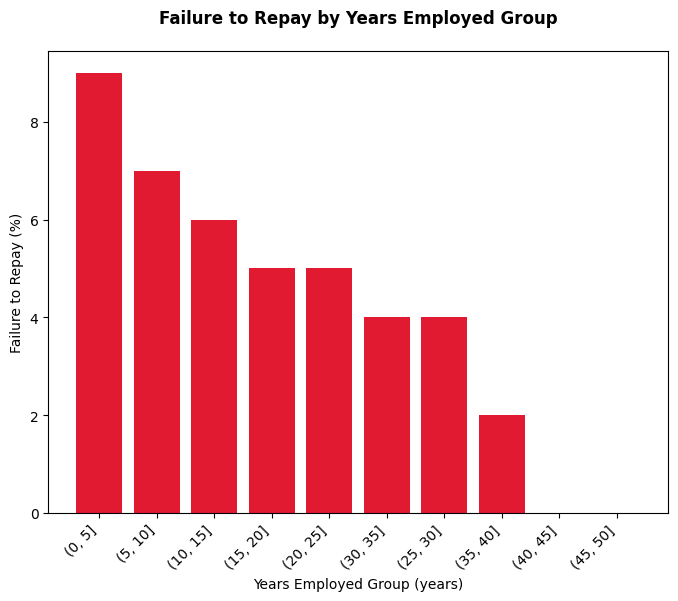

In [124]:
employed = df[['TARGET', 'YEARS_EMPLOYED', 'Age_years']]

# Mengelompokkan dan menghitung rata-rata untuk setiap kelompok
employed_grouped = employed.groupby(pd.cut(employed['YEARS_EMPLOYED'], bins=np.arange(0, 51, 5))).mean()

# Mengurutkan berdasarkan TARGET
employed_grouped = employed_grouped.sort_values('TARGET', ascending=False)

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(employed_grouped.index.astype(str), round(100 * employed_grouped['TARGET']), color='#e11931')
plt.ylabel('Failure to Repay (%)')
plt.xlabel('Years Employed Group (years)')
plt.title('Failure to Repay by Years Employed Group', fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.show()


Visualisasi tersebut menunjukkan bahwa semakin lama masa bekerja client, persentase client yang gagal melunaskan pinjaman cenderung menurun. Artinya client dengan **masa bekerja yang lebih lama** memiliki kecenderungan untuk **melunasi pinjamannya.**

### Business Recomendation

1. Meningkatkan approval untuk client potensial dengan mempertimbangkan skor eksternalnya karena skor eksternal yang besar cenderung untuk mampu melunaskan pinjmannya. Selain itu, untuk meminimalisir client gagal melunasi pinjamannya, dapat diberikan strategi atau ketentuan khusus untuk mendorong pembayaran tepat waktu.
2. Meningkatkan aprroval untuk client yang tinggal di wilayah padat populasi sehingga profitablitas juga dapat meningkat. Namun perlu dibarengi pertimbangan faktor lainnya seperti masa bekerja. Dan pastikan kebijakan tersebut tidak mengabaikan client yang tinggal di wilayah kurang padat.
3. Mempermudah proses pengajuan pinjaman untuk client dengan masa bekerja yang lebih lama, karena mereka cenderung untuk mampu melakukan pelunasan pinjaman. Selain itu, untuk meningkatkan profit perusahaan, client dengan masa bekerja yang lebih lama dapat ditingkatkan limit peminjamannya.